In [2]:
import pandas as pd
# from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver import FirefoxOptions 
from selenium.webdriver.common.by import By
from selenium.webdriver.support.wait import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.keys import Keys
import time
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database

In [231]:
url = 'https://racetozerodataexplorer.org/proceed/'

scope1_lst = []
scope2_local_lst = []
scope2_market_lst = []
name_lst = []

master_lst = [scope1_lst, scope2_local_lst, scope2_market_lst, name_lst]

options = FirefoxOptions()
options.add_argument("--headless") # comment out to see how it works

with webdriver.Firefox(options=options) as driver:
    driver.get(url)
    headers = driver.find_elements(By.XPATH, "//*[@class= 'styles_table__jWPKo']/thead/tr/th")
    headers = [header.text for header in headers]
    table = driver.find_element(By.TAG_NAME, "table").find_element(By.TAG_NAME, "tbody").find_elements(By.TAG_NAME, 'tr')
    
    for row in table:
        name = row.find_element(By.TAG_NAME, 'th')
        # print(name.text)
        master_lst[3].append(name.text)
        for i, cell in enumerate(row.find_elements(By.TAG_NAME, 'td')):
            if i in [0,1,2]: # only interested in first 3 columns
                try:
                    cell.find_element(By.CLASS_NAME, 'styles_button__IS06I').click()
                    WebDriverWait(driver, 10).until( # Wait for pop-up to load
                        EC.presence_of_element_located((By.CLASS_NAME, 'styles_axisValue__ipOq1')))
                    values = driver.find_elements(By.CLASS_NAME, 'styles_axisValue__ipOq1')
                    master_lst[i].append([value.text.replace(',','') for value in values])
                    driver.find_element(By.CLASS_NAME, 'styles_close__cpVjT').click()
                except:
                    master_lst[i].append(['', '', '', ''])

In [213]:
industries = [
    'Basic Materials',
    'Communication Services',
    'Consumer Cyclicals',
    'Consumer Discretionary',
    'Consumer Non-Cyclicals',
    'Consumer Staples',
    'Energy',
    'Health Care',
    'Industrials',
    'Information Technology',
    'Materials',
    'Real Estate',
    'Technology',
    'Utilities',
]

sectors = []

with webdriver.Firefox(options=options) as driver:
    driver.get(url)
    for industry in industries:
        filter = driver.find_element(By.ID, 'react-select-q-input')
        filter.click()
        filter.send_keys(industry)
        time.sleep(0.2)
        if industry in ['Materials', 'Technology']:
            filter.send_keys(Keys.DOWN)
        filter.send_keys(Keys.ENTER)
        time.sleep(0.2)
        table = driver.find_element(By.TAG_NAME, "table").find_element(By.TAG_NAME, 'tbody')
        names = table.find_elements(By.TAG_NAME, 'th')
        for name in names:
            sectors.append([industry, name.text])
        driver.find_element(By.CLASS_NAME, 'css-g010ao').click()
    

In [228]:
headers = [header.strip().replace('\n', ' ').replace(
    '4 years trend (ending in reporting year)', '') for header in headers]
years = ['2018', '2019', '2020', '2021']
    
# Need to merge all these 
df_scope1 = pd.DataFrame(master_lst[0], index=master_lst[3], columns=years).reset_index(drop=False)
df_scope2_loc = pd.DataFrame(master_lst[1], index=master_lst[3], columns=years).reset_index(drop=False)
df_scope2_mkt = pd.DataFrame(master_lst[2], index=master_lst[3], columns=years).reset_index(drop=False)

df_sectors = pd.DataFrame(master_lst[4], columns=['Industry'], index=master_lst[3])

In [4]:
engine = create_engine("sqlite:///GDS.db")
if not database_exists(engine.url):
    create_database(engine.url)

# Add dataframes to database to avoid having to rerun webscraping each time
for df, header in [(df_scope1, headers[1]), (df_scope2_loc, headers[2]), (df_scope2_mkt, headers[3])]:
    df.rename(columns={'index': 'Company Name'}, inplace=True)
    df.to_sql(header.replace(' ', '_'), engine, if_exists='replace', index=False)

df_sector.to_sql('Sectors', engine, if_exists="replace", index=False) 

In [5]:
df_scope1 = pd.read_sql_table('Scope_1_emissions_(tCO₂e)', engine)
df_scope2_loc = pd.read_sql_table('Scope_2_emissions_(tCO₂e)_Location', engine)
df_scope2_mkt = pd.read_sql_table('Scope_2_emissions_(tCO₂e)_Market', engine)

df_sectors = pd.read_sql_table('Sectors', engine)

In [8]:
# Drop Interpublic Group of Companies, Inc. which is duplicated in data source
df_scope1 = df_scope1.loc[~df_scope1.index.duplicated()] 
df_scope2_loc = df_scope2_loc.loc[~df_scope2_loc.index.duplicated()] 
df_scope2_mkt = df_scope2_mkt.loc[~df_scope2_mkt.index.duplicated()] 

In [9]:
df_scope1 = df_scope1.melt(id_vars='Company Name', value_name='Scope_1_emissions_(tCO₂e)', var_name='Year')
df_scope2_loc = df_scope2_loc.melt(id_vars='Company Name', value_name='Scope_2_emissions_(tCO₂e)_Location', var_name='Year')
df_scope2_mkt = df_scope2_mkt.melt(id_vars='Company Name', value_name='Scope_2_emissions_(tCO₂e)_Market', var_name='Year')

In [10]:
df = df_scope1.merge(df_scope2_loc, on=['Company Name', 'Year']).merge(df_scope2_mkt, on=['Company Name', 'Year'])

df = df.loc[~df.duplicated()] # Remove companies with no data whatsoever

In [12]:
companies_sample = pd.DataFrame(df['Company Name'].unique(), columns=['Company Name']).sample(100, random_state=1234)

df = df.merge(companies_sample, on='Company Name', how='inner')
df.replace('', '-', inplace=True)
df.to_sql('Emissions_Data_Joined', engine, if_exists='replace', index=False)

400

In [13]:
df = pd.read_sql_table('Emissions_Data_Joined', engine)

In [14]:
df[['Year', 'Scope_1_emissions_(tCO₂e)']].loc[df['Scope_1_emissions_(tCO₂e)']!='-'].astype(int).groupby('Year').describe()

Scope_1_emissions_(tCO₂e)                                               \
                         count          mean           std    min       25%   
Year                                                                          
2018                      72.0  3.729090e+06  1.606448e+07    2.0  22828.75   
2019                      84.0  2.719290e+06  1.148106e+07  129.0  26652.25   
2020                      89.0  2.318300e+06  9.093824e+06   32.0  21802.00   
2021                      92.0  2.598275e+06  1.047223e+07   41.0  20332.50   

                                        
           50%        75%          max  
Year                                    
2018  169850.0  309727.50  120400000.0  
2019  136754.0  315295.00   89836000.0  
2020  117400.0  293000.00   70200000.0  
2021  135402.5  394161.25   86900000.0

In [168]:
df[['Year', 'Scope_2_emissions_(tCO₂e)_Location']].loc[df['Scope_2_emissions_(tCO₂e)_Location']!='-'].astype(int).groupby('Year').describe()

Scope_2_emissions_(tCO₂e)_Location                                       \
                                  count           mean           std     min   
Year                                                                           
2018                               71.0  630327.802817  1.051652e+06  2347.0   
2019                               80.0  624356.075000  1.067022e+06  2701.0   
2020                               86.0  618965.453488  1.101812e+06   116.0   
2021                               86.0  589840.697674  9.897317e+05   900.0   

                                                
           25%       50%        75%        max  
Year                                            
2018  46839.00  199959.0  718684.00  5224000.0  
2019  44086.75  180588.0  626570.50  5500000.0  
2020  37045.50  162902.5  606539.50  5270000.0  
2021  39934.00  137089.0  569644.75  4635217.0

In [169]:
df[['Year', 'Scope_2_emissions_(tCO₂e)_Market']].loc[df['Scope_2_emissions_(tCO₂e)_Market']!='-'].astype(int).groupby('Year').describe()

Scope_2_emissions_(tCO₂e)_Market                                      \
                                count          mean           std     min   
Year                                                                        
2018                             51.0  5.952588e+05  9.634727e+05  1861.0   
2019                             62.0  5.423894e+05  9.476501e+05   162.0   
2020                             69.0  2.519844e+06  1.694023e+07    82.0   
2021                             72.0  4.262941e+05  7.867337e+05   229.0   

                                                  
           25%       50%        75%          max  
Year                                              
2018  37824.00  245505.0  583025.00    5105000.0  
2019  29974.25  144128.0  378309.75    5220350.0  
2020  18048.00   90818.0  336092.00  141000000.0  
2021  16539.00   78129.0  356163.00    3748840.0

In [39]:
import matplotlib.pyplot as plt

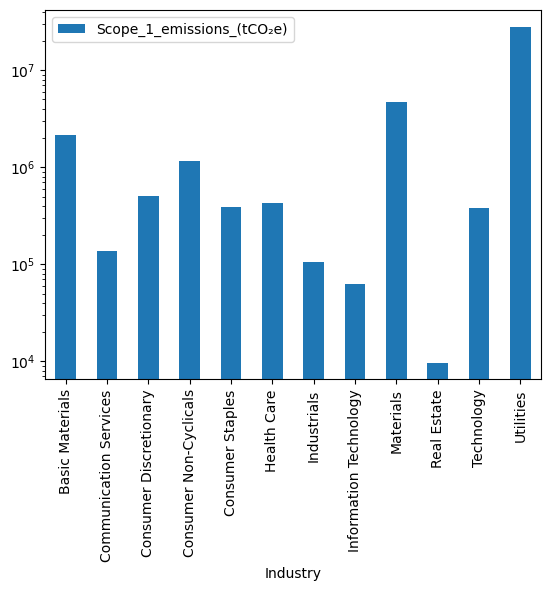

In [40]:
df_plot = df[['Company Name', 'Scope_1_emissions_(tCO₂e)']].merge(df_sectors, on='Company Name').loc[df['Scope_1_emissions_(tCO₂e)']!='-']
df_plot['Scope_1_emissions_(tCO₂e)'] = df_plot['Scope_1_emissions_(tCO₂e)'].astype(int)

df_plot.groupby('Industry').mean().plot(kind='bar')
plt.yscale(value='log')
plt.show()

In [ ]:
from bs4 import BeautifulSoup
import pandas as pd
import requests

In [ ]:
with open('C:/Users/sofia/OneDrive - University College Dublin/Trimester 3/Green Data Science/RaceToZeroProceed.html') as file:
    soup = BeautifulSoup(file.read(), 'html.parser')

table = soup.find('table', class_='styles_table__jWPKo')

data = pd.DataFrame([])
for row in table.find_all('tr'):
    row_data = []
    company = row.find_all('th', {'scope': 'row', 'data-width': 's'})
    for c in company:
        row_data.append(c.get_text(strip=True))
    data = data.append(pd.Series(row_data), ignore_index=True)
print(data)

In [ ]:
ticker = "https://stockanalysis.com/stocks/"
page = requests.get(ticker)
soup = BeautifulSoup(page.content, 'html.parser')

box = soup.find('table', class_='svelte-1jtwn20')

data = []
table = box.find('tbody', class_='svelte-1jtwn20')
for row in table.find_all('tr', class_='svelte-1jtwn20'):
    row_data = []
    for td in row.find_all('td', class_='svelte-1jtwn20'):
        row_data.append(td.get_text(strip=True))
    data.append(row_data)

df = pd.DataFrame(data)
print(df)